**Credit Card Fraud Detection**

Import Libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

Load Dataset

In [2]:
df = pd.read_csv("fraud_data.csv")

In [3]:
# Preview the Dataset
df.head()

,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud
0,04-01-2019 00:58,"""Stokes, Christiansen and Sipes""",grocery_net,14.37,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a3806e984cec6ac0096d8184c64ad3a1,65.654142,-164.722603,1
1,04-01-2019 15:06,Predovic Inc,shopping_net,966.11,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a59185fe1b9ccf21323f581d7477573f,65.468863,-165.473127,1
2,04-01-2019 22:37,Wisozk and Sons,misc_pos,49.61,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,86ba3a888b42cd3925881fa34177b4e0,65.347667,-165.914542,1
3,04-01-2019 23:06,Murray-Smitham,grocery_pos,295.26,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,3a068fe1d856f0ecedbed33e4b5f4496,64.445035,-166.080207,1
4,04-01-2019 23:59,Friesen Lt,health_fitness,18.17,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,891cdd1191028759dc20dc224347a0ff,65.447094,-165.446843,1


In [4]:
# Dataset Shape
df.shape

(14446, 15)

In [5]:
# Dataset Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14446 entries, 0 to 14445
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trans_date_trans_time  14446 non-null  object 
 1   merchant               14446 non-null  object 
 2   category               14446 non-null  object 
 3   amt                    14446 non-null  float64
 4   city                   14446 non-null  object 
 5   state                  14446 non-null  object 
 6   lat                    14446 non-null  float64
 7   long                   14446 non-null  float64
 8   city_pop               14446 non-null  int64  
 9   job                    14446 non-null  object 
 10  dob                    14446 non-null  object 
 11  trans_num              14446 non-null  object 
 12  merch_lat              14446 non-null  float64
 13  merch_long             14446 non-null  float64
 14  is_fraud               14446 non-null  object 
dtypes:

In [6]:
# Statistical Summary
df.describe()

,amt,lat,long,city_pop,merch_lat,merch_long
count,14446.000000,14446.000000,14446.000000,1.444600e+04,14446.000000,14446.000000
mean,124.430073,39.787692,-110.874225,1.065370e+05,39.787991,-110.874892
std,231.352587,5.317039,12.985813,2.902916e+05,5.360593,12.995596
min,1.000000,20.027100,-165.672300,4.600000e+01,19.032689,-166.670685
25%,12.080000,36.715400,-120.415800,4.930000e+02,36.794655,-120.146253
50%,51.520000,39.666200,-111.098500,1.645000e+03,39.620953,-111.192629
75%,101.030000,41.940400,-101.136000,3.543900e+04,42.275740,-100.446822
max,3261.470000,66.693300,-89.628700,2.383912e+06,67.510267,-88.646366


In [7]:
df.columns

Index(['trans_date_trans_time', 'merchant', 'category', 'amt', 'city', 'state',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

Target column is 'is_fraud'

In [8]:
# Check Class Distribution (Important for Fraud Detection)
df['is_fraud'].value_counts()

is_fraud
0                         12600
1                          1844
1"2020-12-24 16:56:24"        1
0"2019-01-01 00:00:44"        1
Name: count, dtype: int64

That means:
- Some rows have values like 1"2020-12-24 16:56:24"
- Some rows have 0"2019-01-01 00:00:44"
>This usually happens due to CSV parsing issues or bad joins
- Goal: Convert is_fraud into a clean binary column (0 / 1).

In [9]:
# Inspect Unique Values
df['is_fraud'].unique()

array(['1', '1"2020-12-24 16:56:24"', '0', '0"2019-01-01 00:00:44"'],
      dtype=object)

In [10]:
# Clean the is_fraud Column
df['is_fraud'] = df['is_fraud'].astype(str).str[0].astype(int)

In [11]:
# Verify Cleaned Distribution
df['is_fraud'].value_counts()

is_fraud
0    12601
1     1845
Name: count, dtype: int64

Separate Features and Target

In [12]:
# Target variable
y = df['is_fraud']

# Feature set (drop target)
X = df.drop(columns=['is_fraud'])

# 'Identify Non-Useful Identifier Columns'
These columns do not help prediction and may cause leakage or overfitting.
Why we remove them:
- trans_num → unique transaction ID (no predictive value)
- trans_date_trans_time → raw timestamp (needs feature engineering, not direct use)
- dob → raw date of birth (will convert to age later)

In [13]:
identifier_cols = [
    'trans_num',
    'trans_date_trans_time',
    'dob'
]

X.drop(columns=identifier_cols, inplace=True)

In [14]:
# Verify Remaining Features
X.head()

,merchant,category,amt,city,state,lat,long,city_pop,job,merch_lat,merch_long
0,"""Stokes, Christiansen and Sipes""",grocery_net,14.37,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",65.654142,-164.722603
1,Predovic Inc,shopping_net,966.11,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",65.468863,-165.473127
2,Wisozk and Sons,misc_pos,49.61,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",65.347667,-165.914542
3,Murray-Smitham,grocery_pos,295.26,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",64.445035,-166.080207
4,Friesen Lt,health_fitness,18.17,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",65.447094,-165.446843


In [15]:
# Check Feature Data Types
X.dtypes

merchant       object
category       object
amt           float64
city           object
state          object
lat           float64
long          float64
city_pop        int64
job            object
merch_lat     float64
merch_long    float64
dtype: object

In [16]:
from sklearn.model_selection import train_test_split
# Stratified Train–Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

- stratify=y → preserves fraud ratio
- test_size=0.2 → 80% train, 20% test
- random_state=42 → reproducibility

In [17]:
# Verify Class Distribution
print("Train set class distribution:")
print(y_train.value_counts(normalize=True) * 100)

print("\nTest set class distribution:")
print(y_test.value_counts(normalize=True) * 100)

Train set class distribution:
is_fraud
0    87.227414
1    12.772586
Name: proportion, dtype: float64

Test set class distribution:
is_fraud
0    87.231834
1    12.768166
Name: proportion, dtype: float64


Train a baseline model like Logistic Regression for comparison

In [18]:
# Import Required Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
# Separate Categorical and Numerical Features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

categorical_features, numerical_features

(Index(['merchant', 'category', 'city', 'state', 'job'], dtype='object'),
 Index(['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long'], dtype='object'))

Preprocessing Pipeline
- OneHotEncode categorical features
- Scale numerical features
- Combine using ColumnTransformer

In [20]:
# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [21]:
# Logistic Regression Pipeline
log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',  # important for imbalanced data
        random_state=42
    ))
])

In [22]:
# Train the Baseline Model
log_reg_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [23]:
# Make Predictions
y_pred = log_reg_pipeline.predict(X_test)

In [24]:
# Evaluate Baseline Model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[2244  277]
 [  65  304]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      2521
           1       0.52      0.82      0.64       369

    accuracy                           0.88      2890
   macro avg       0.75      0.86      0.78      2890
weighted avg       0.91      0.88      0.89      2890



Train Random Forest model with parameters like n_estimators=100.

In [25]:
# Import Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [26]:
# Random Forest Pipeline
'''Important: Random Forest does not need feature scaling, but it does need encoded categorical features. 
We’ll reuse OneHotEncoder, but remove StandardScaler.'''
rf_preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [27]:
# Define Random Forest Model
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

In [28]:
# Build Pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', rf_preprocessor),
    ('classifier', rf_model)
])

In [30]:
# Train Random Forest
rf_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [31]:
# Make Predictions
y_pred_rf = rf_pipeline.predict(X_test)

In [32]:
# Evaluate Random Forest
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

Confusion Matrix:
[[2502   19]
 [  76  293]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2521
           1       0.94      0.79      0.86       369

    accuracy                           0.97      2890
   macro avg       0.95      0.89      0.92      2890
weighted avg       0.97      0.97      0.97      2890



Predict and evaluate using precision, recall, F1-score instead of accuracy

In [33]:
# Import Metrics
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate Fraud-Focused Metrics
precision = precision_score(y_test, y_pred_rf, pos_label=1)
recall = recall_score(y_test, y_pred_rf, pos_label=1)
f1 = f1_score(y_test, y_pred_rf, pos_label=1)

print(f"Precision (Fraud): {precision:.3f}")
print(f"Recall (Fraud): {recall:.3f}")
print(f"F1-score (Fraud): {f1:.3f}")

Precision (Fraud): 0.939
Recall (Fraud): 0.794
F1-score (Fraud): 0.860


Based on your report:
- Precision ≈ 0.94 → Very few false fraud alerts
- Recall ≈ 0.79 → Most frauds are caught
- F1-score ≈ 0.86 → Strong balance between precision & recall

In [34]:
# Threshold-Based Evaluation
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]
y_pred_threshold = (y_prob_rf >= 0.3).astype(int)

print(classification_report(y_test, y_pred_threshold))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2521
           1       0.84      0.87      0.85       369

    accuracy                           0.96      2890
   macro avg       0.91      0.92      0.92      2890
weighted avg       0.96      0.96      0.96      2890



| Model               | Fraud Precision | Fraud Recall | Fraud F1 |
|---------------------|-----------------|--------------|----------|
| Logistic Regression | 0.52            | 0.82         | 0.64     |
| Random Forest       | 0.94            | 0.79         | 0.86     |

- Lower threshold → higher recall, lower precision
- Common in real fraud systems


Plot feature importances to identify key fraud indicators

In [40]:
# Get numerical feature names After Encoding
num_features = numerical_features

# Get categorical feature names after OneHotEncoding
cat_encoder = rf_pipeline.named_steps['preprocessor'] \
                          .named_transformers_['cat']

cat_features = cat_encoder.get_feature_names_out(categorical_features)

# Combine all feature names
feature_names = list(num_features) + list(cat_features)

In [42]:
# Extract Feature Importances
importances = rf_pipeline.named_steps['classifier'].feature_importances_

In [43]:
# Create Feature Importance DataFrame
import pandas as pd

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

feature_importance_df.head(10)

,feature,importance
0,amt,0.430694
4,merch_lat,0.040615
5,merch_long,0.039761
703,category_grocery_pos,0.019346
710,category_shopping_net,0.018088
701,category_gas_transport,0.017045
1,lat,0.016777
3,city_pop,0.016757
2,long,0.015044
705,category_home,0.011615


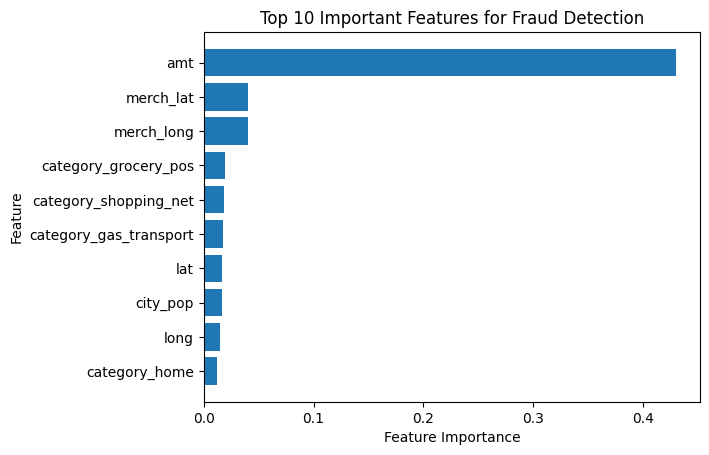

In [44]:
# Plot Top 10 Important Features
import matplotlib.pyplot as plt

top_n = 10
top_features = feature_importance_df.head(top_n)

plt.figure()
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Important Features for Fraud Detection")
plt.gca().invert_yaxis()
plt.show()

### Logistic Regression vs Random Forest (Fraud Detection)

| Metric (Fraud Class) | Logistic Regression | Random Forest |
|---------------------|---------------------|---------------|
| Precision           | 0.52                | 0.94          |
| Recall              | 0.82                | 0.79          |
| F1-score            | 0.64                | 0.86          |
| Overall Accuracy    | 0.88                | 0.97          |

Key Observations
- Logistic Regression achieves higher recall, meaning it catches more frauds but produces many false positives.
- Random Forest significantly improves precision, reducing false fraud alerts.
- Random Forest achieves the highest F1-score, indicating a better balance between precision and recall.
- Accuracy improves substantially with Random Forest, but accuracy is not the primary evaluation metric due to class imbalance.


In [45]:
# Import joblib
import joblib
# Save the Model
model_path = "model.joblib"
joblib.dump(rf_pipeline, model_path)

print(f"Model saved successfully at: {model_path}")

Model saved successfully at: model.joblib


In [46]:
# Save Model as .pkl
import joblib
# Save the best model (Random Forest pipeline)
joblib.dump(rf_pipeline, "model.pkl")

print("Model saved successfully as model.pkl")

Model saved successfully as model.pkl
